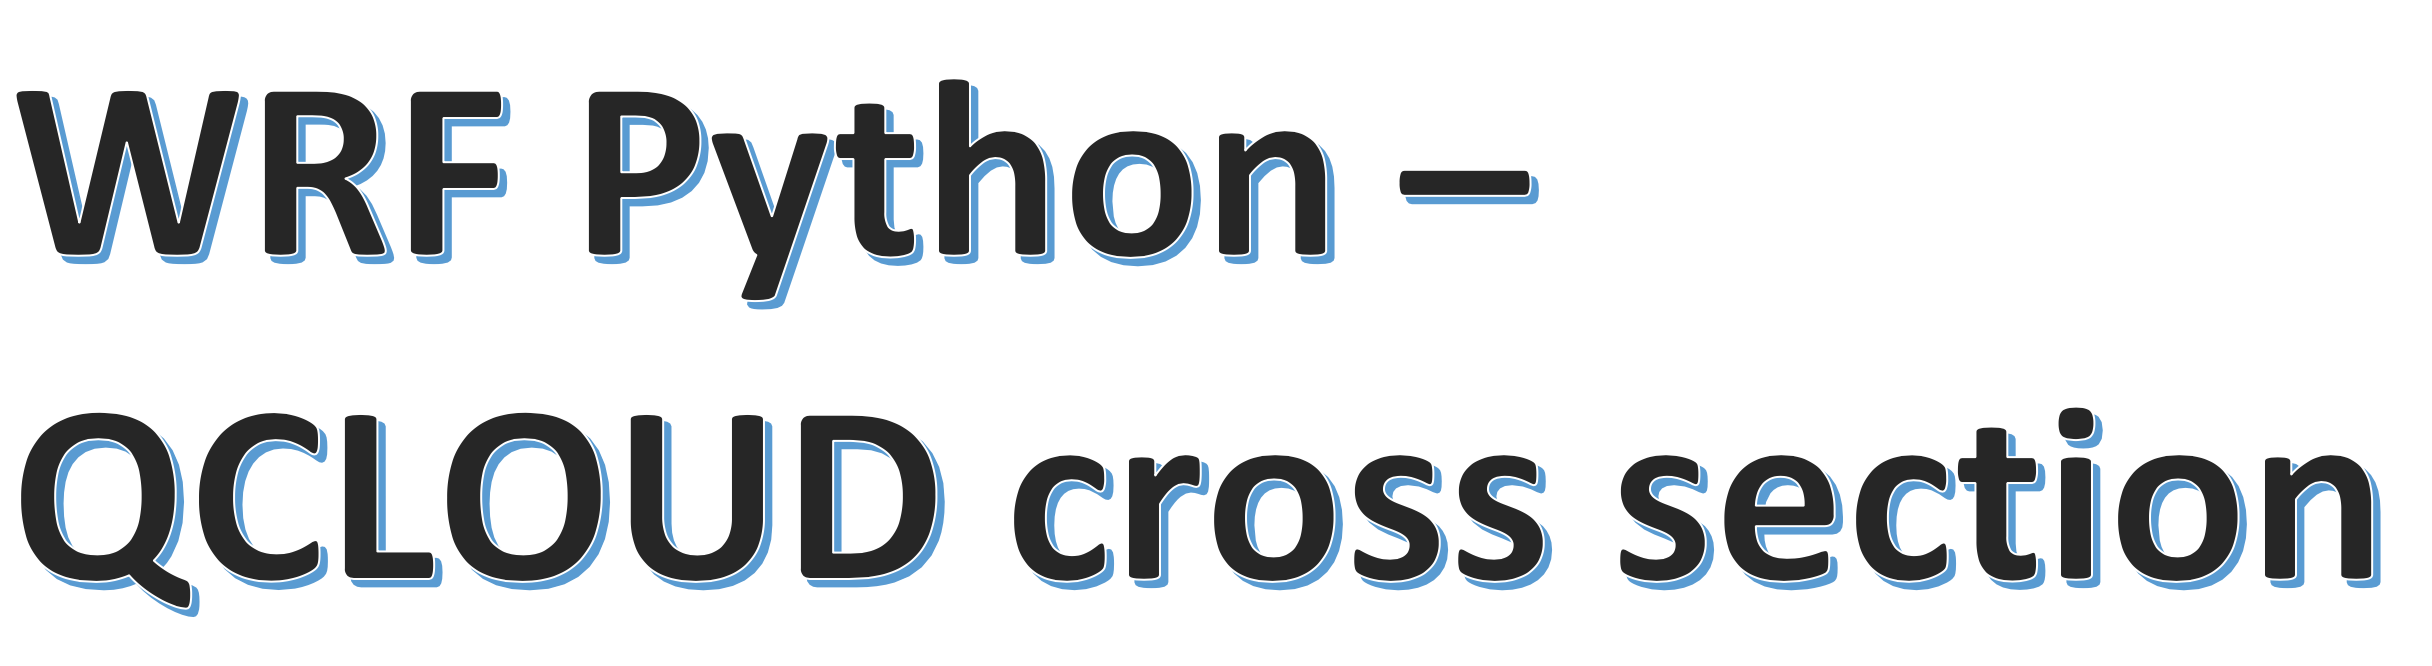

In [1]:
from IPython.display import Image
Image('09overview.png')

In this tutorial, we will learn how to plot a cross section of QCLOUD with mountain height plot for a particular output of WRF model.
Referrence: 
https://wrf-python.readthedocs.io/en/latest/index.html

# 1. Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from cartopy import crs
from cartopy.feature import NaturalEarthFeature, COLORS
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair)

/Users/sonnytruong/soft_install/anaconda3/envs/PhD/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


# 2. Download data

In [18]:
import glob
# specify where is the location of the data
path_in = "data2/"
path_out = "./"

wrf_file = []
for i in glob.glob('data2/*.nc'):
    print(i)
    wrf_file_ = Dataset(i)
    wrf_file.append(wrf_file_)
    print(len(wrf_file))
# print(wrf_file[0])
# print(wrf_file[1])


data2/wrfout_d03_2018-08-03_16_30_00.nc
1
data2/wrfout_d03_2018-08-03_16_00_00.nc
2


In [20]:
ht = []; ter = []; QCLOUD = []
for i in range(len(wrf_file)):
    ht_  = getvar(wrf_file[i], "z", timeidx=-1)
    ter_ = getvar(wrf_file[i], "ter", timeidx=-1)
    QCLOUD_ = getvar(wrf_file[i], "QCLOUD", timeidx=-1)

    ht.append(ht_); ter.append(ter_); QCLOUD.append(QCLOUD_)

print(len(ht))
print(len(ter))
print(len(QCLOUD))
print(np.shape(ht[0]))
print(np.shape(ter[0]))
print(np.shape(QCLOUD[0]))
print(QCLOUD[0].attrs)

2
2
2
(64, 345, 465)
(345, 465)
(64, 345, 465)
{'FieldType': 104, 'MemoryOrder': 'XYZ', 'description': 'Cloud water mixing ratio', 'units': 'kg kg-1', 'stagger': '', 'coordinates': 'XLONG XLAT XTIME', 'projection': LambertConformal(stand_lon=148.01199340820312, moad_cen_lat=-36.25400924682617, truelat1=-36.25400161743164, truelat2=-36.25400161743164, pole_lat=90.0, pole_lon=0.0)}


In [21]:
sum_ht = 0; sum_ter = 0; sum_qcloud = 0
for i in range(0,len(wrf_file)):
    print(i)
    sum_ht += ht[i]
    sum_ter += ter[i]
    sum_qcloud += QCLOUD[i]

ave_ht = sum_ht/len(wrf_file)
ave_ter = sum_ter/len(wrf_file)
ave_qcloud = sum_qcloud/len(wrf_file)
ave_qcloud = ave_qcloud * 1000

ave_qcloud.attrs.update(QCLOUD[0].attrs)
ave_qcloud.attrs["units"] = "g/kg"

print(ave_qcloud.attrs)
print(np.shape(ave_ht))
print(np.shape(ave_ter))
print(np.shape(ave_qcloud))
# ==========CHECKING=================
print('====checking====')
print(np.shape(sum_qcloud))
print(np.shape(ave_qcloud))
print(sum_qcloud[15,100,100].values)
print(ave_qcloud[15,100,100].values)

# double check
a = QCLOUD[0]+QCLOUD[1]
ave_a = a/2
print(a[15,100,100].values)
print(ave_a[15,100,100].values)
print('====DONE checking====')
# ==========DONE CHECKING============

0
1
{'FieldType': 104, 'MemoryOrder': 'XYZ', 'description': 'Cloud water mixing ratio', 'units': 'g/kg', 'stagger': '', 'coordinates': 'XLONG XLAT XTIME', 'projection': LambertConformal(stand_lon=148.01199340820312, moad_cen_lat=-36.25400924682617, truelat1=-36.25400161743164, truelat2=-36.25400161743164, pole_lat=90.0, pole_lon=0.0)}
(64, 345, 465)
(345, 465)
(64, 345, 465)
====checking====
(64, 345, 465)
(64, 345, 465)
0.00015496182
0.07748091
0.00015496182
7.748091e-05
====DONE checking====


In [13]:
del ht
del ter
del QCLOUD

# 3. Take out the variables

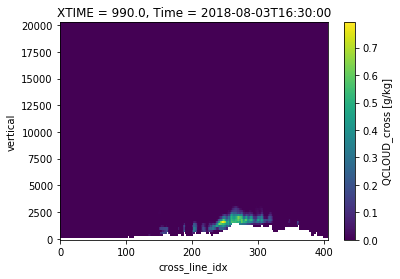

In [23]:
# Define the cross section start and end points
cross_start = CoordPair(lat=-35.9, lon=145.5)
cross_end   = CoordPair(lat=-35.9, lon=150)

# Get the WRF variables
ht  = ave_ht
ter = ave_ter
#Cloud water mixing ratio
QCLOUD = ave_qcloud
    
# print(QCLOUD)

# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section in the metadata by setting latlon
# to True.
z_cross = vertcross(QCLOUD, ht, wrfin=wrf_file[0],
                    start_point=cross_start,
                    end_point=cross_end,
                    latlon=True, 
                    meta=True)

z_cross.plot()
# print(z_cross)

# Make a copy of the z cross data. Let's use regular numpy arrays for this.
dbz_cross_filled = np.ma.copy(to_np(z_cross))

# For each cross section column, find the first index with non-missing
# values and copy these to the missing elements below.
for i in range(dbz_cross_filled.shape[-1]):
    column_vals = dbz_cross_filled[:,i]
    first_idx = int(np.transpose((column_vals > -10).nonzero())[0])
    dbz_cross_filled[0:first_idx, i] = dbz_cross_filled[first_idx, i]

# Get the terrain heights along the cross section line
ter_line = interpline(ter, wrfin=wrf_file[0], start_point=cross_start,
                      end_point=cross_end)

# Get the lat/lon points
lats, lons = latlon_coords(QCLOUD)

# Get the cartopy projection object
cart_proj = get_cartopy(QCLOUD)

# 4. Plotting

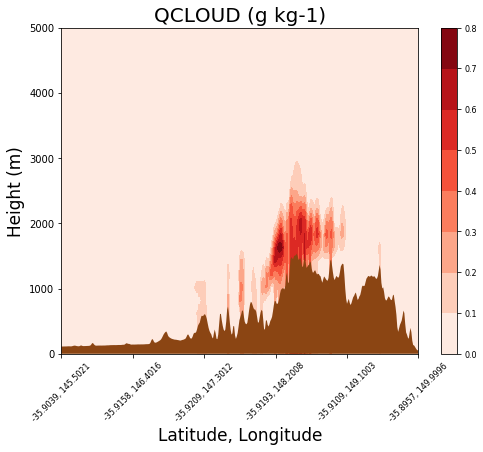

In [25]:
# Create the figure
fig = plt.figure(figsize=(8,6))
ax_cross = plt.axes()

xs = np.arange(0, z_cross.shape[-1], 1)
ys = to_np(z_cross.coords["vertical"])
QCLOUD_contours = ax_cross.contourf(xs,
                                 ys,
                                 to_np(dbz_cross_filled),
                                 cmap="Reds")

# Add the color bar
cb_QCLOUD = fig.colorbar(QCLOUD_contours, ax=ax_cross)
cb_QCLOUD.ax.tick_params(labelsize=8)

# Fill in the mountain area
ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line),
                                facecolor="saddlebrown")

# Set the x-ticks to use latitude and longitude labels
coord_pairs = to_np(z_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]

# Set the desired number of x ticks below
num_ticks = 5
thin = int((len(x_ticks) / num_ticks) + .5)
ax_cross.set_xticks(x_ticks[::thin])
ax_cross.set_xticklabels(x_labels[::thin], rotation=45, fontsize=8)

# Set the x-axis and  y-axis labels
ax_cross.set_xlabel("Latitude, Longitude", fontsize=17)
ax_cross.set_ylabel("Height (m)", fontsize=17)

# Set the range of y-axis
ax_cross.set_ylim([0,5000])

# Add a title
ax_cross.set_title("QCLOUD (g kg-1)", {"fontsize" : 20})

plt.show()

## All done !!!
- Please feel free to let me know if there is any analysis that you would like me to do
- Please subscribe my youtube channel too
- Thank you very much